Here, I'm generally setting up the computational space.  The goal is to figure out what makes Ogden School District unique, or what suprising information we can find.  We have some of their financial, demographic, and assessment data that we'll compare.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')

Now I'd like to provide a set of transformers to translate the percent data into something useful.  We get regular percentages (58.6%), ranges (10-15%), upper bounds (≤5% or N≤5%), and lower bounds (≥90% or N≥90%).  These transformers turn all of these input types into an estimated mean value.

In [2]:
import re

def general_clean(x):
    return x.strip('N').strip('%')

def to_percent(x):
    return float(x)/100.

def percent_to_float(x):
    return to_percent(general_clean(x))

def diff_to_percent(a, b):
    a = float(general_clean(a))
    b = float(general_clean(b))
    diff = (b - a) / 2.
    return to_percent(a + diff)

def range_to_mean_float(x):
    a, b = x.split('-')
    return diff_to_percent(a, b)

def zero_to_value(x):
    b = general_clean(x).strip('≤')
    return diff_to_percent('0', b)

def value_to_one_hundred(x):
    a = general_clean(x.strip('≥'))
    return diff_to_percent(a, '100.')

def general_parse(x):
    if re.search("\d+-\d+", x):
        return range_to_mean_float(x)
    elif re.search("≤\d+", x):
        return zero_to_value(x)
    elif re.search("≥\d+", x):
        return value_to_one_hundred(x)
    else:
        return percent_to_float(x)

As a quick test, I run each pattern I've observed through the general parser to make sure it returns expected results.

In [3]:
list(map(general_parse, ['58.4%', '11-19%', '≤5%', '≥90%', 'N≤10']))

[0.584, 0.15, 0.025, 0.95, 0.05]

Now I'm ready to load the best SAGE assessment data I have for Ogden School District.  This is for the 2014 and 2015 school years.  This produces data tables of each set of data.  I then combine both data sets, trusting the school year label on each row.

In [4]:
sage_2014 = pd.read_csv('sage_2014.csv', converters={'Percent Proficient':general_parse})
sage_2015 = pd.read_csv('sage_2015.csv', converters={'Percent Proficient':general_parse})
sage = pd.concat([sage_2014 , sage_2015], axis=0)

To take a quick look at the data, I'll print out the first few rows.  Notice most of the data is categorical (School Year, District/LEA, School Name, Subject Area and Subject).  Only the Percent Proficient is continuous numerical data.

In [5]:
sage.head()

,School Year,District/LEA,School Name,Subject Area,Subject,Percent Proficient
0,2014,ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),L,9th Grade Language Arts,0.584
1,2014,ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),L,10th Grade Language Arts,0.664
2,2014,ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),L,11th Grade Language Arts,0.447
3,2014,ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),M,Secondary Math I,0.336
4,2014,ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),ACADEMY FOR MATH ENGINEERING & SCIENCE (AMES),M,Secondary Math II,0.397


I can take a closer look at the percent proficient in several ways.

In [6]:
proficiency = sage['Percent Proficient']
proficiency.describe()

count    21379.000000
mean         0.387687
std          0.215079
min          0.010000
25%          0.239000
50%          0.400000
75%          0.539000
max          0.975000
Name: Percent Proficient, dtype: float64

These are some general tools for plotting histograms.

In [7]:
common_params = dict(bins=20, 
                     range=(0, 1), 
                     alpha=0.75,
                     normed=True)

def hist_plot(series, title):
    plt.hist(list(series), **common_params)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

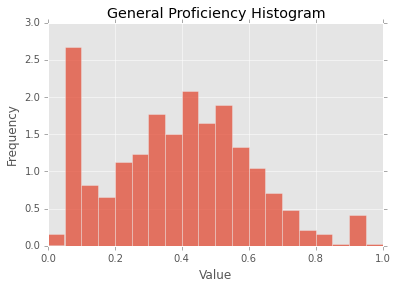

General proficiency mean: 0.39, standard deviation 0.22


In [8]:
hist_plot(proficiency, "General Proficiency Histogram")
print("General proficiency mean: %2.2f, standard deviation %2.2f" % (proficiency.mean(), proficiency.std()))

Interesting, the data looks roughly normal with a high category of not-proficient pupils.  I would like to correlate ELL students with these proficiency numbers when I get a chance.

Here, we notice the types of SAGE testing (for the uninitiated).

In [9]:
sage['Subject Area'].unique()

array(['L', 'M', 'S'], dtype=object)

Looking at the specific subjects, we see that these mean Language Arts, Math and Science.

The following is each type of assessment visualized.

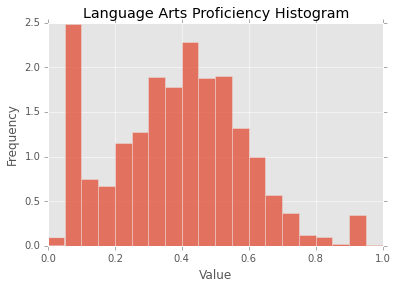

Language Arts mean: 0.38, standard deviation 0.20


In [10]:
language_arts = sage[sage['Subject Area'] == 'L']
language_arts_proficiency = language_arts['Percent Proficient']
hist_plot(language_arts_proficiency, "Language Arts Proficiency Histogram")
print("Language Arts mean: %2.2f, standard deviation %2.2f" % (language_arts_proficiency.mean(), language_arts_proficiency.std()))

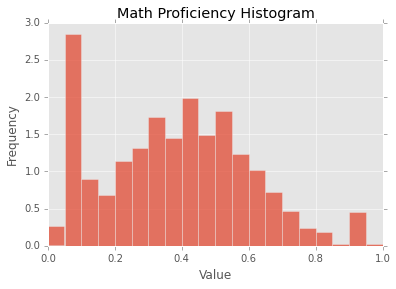

Math mean: 0.38, standard deviation 0.22


In [11]:
math = sage[sage['Subject Area'] == 'M']
math_proficiency = math['Percent Proficient']
hist_plot(math_proficiency, "Math Proficiency Histogram")
print("Math mean: %2.2f, standard deviation %2.2f" % (math_proficiency.mean(), math_proficiency.std()))

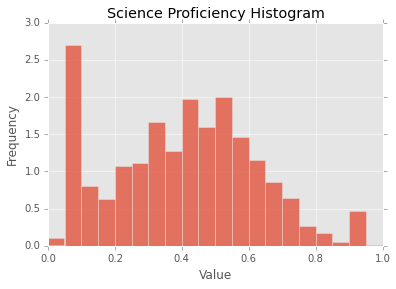

Science mean: 0.40, standard deviation 0.22


In [12]:
science = sage[sage['Subject Area'] == 'S']
science_proficiency = science['Percent Proficient']
hist_plot(science_proficiency, "Science Proficiency Histogram")
print("Science mean: %2.2f, standard deviation %2.2f" % (science_proficiency.mean(), science_proficiency.std()))

In [13]:
ogden = sage[sage['District/LEA'] == 'OGDEN CITY DISTRICT']
ogden_proficiency = ogden['Percent Proficient']
print("Ogden mean: %2.2f, standard deviation %2.2f" % (ogden_proficiency.mean(), ogden_proficiency.std()))

Ogden mean: 0.29, standard deviation 0.21


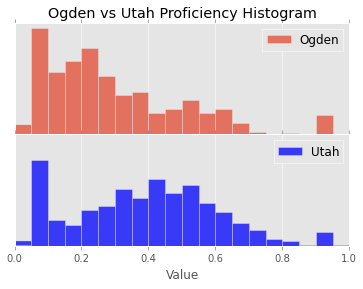

In [14]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.hist(list(ogden_proficiency), label="Ogden", **common_params)
ax2.hist(list(proficiency), label="Utah", color="blue", **common_params)
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
ax1.set_title("Ogden vs Utah Proficiency Histogram")
plt.xlabel("Value")
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax1.axes.get_yaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
plt.show()

We see that Ogden School District has a different distribution for their SAGE assessments.  It is skewed to the lower end of the scale.

In [15]:
ogden.describe()

,School Year,Percent Proficient
count,473.000000,473.000000
mean,2014.439746,0.290429
std,0.496882,0.206782
min,2014.000000,0.010000
25%,2014.000000,0.138000
50%,2014.000000,0.235000
75%,2015.000000,0.407000
max,2015.000000,0.950000


We still have 473 results to understand.  Let's break those into schools and types and see what we see.

In [16]:
ogden['School Name'].unique()

array(['ODYSSEY SCHOOL', 'JAMES MADISON SCHOOL', 'HERITAGE SCHOOL',
       'SHADOW VALLEY SCHOOL', 'TAYLOR CANYON SCHOOL', 'BONNEVILLE SCHOOL',
       'DEE SCHOOL', 'GRAMERCY SCHOOL', 'HILLCREST SCHOOL',
       'HORACE MANN SCHOOL', 'LINCOLN SCHOOL', 'POLK SCHOOL',
       'THOMAS O SMITH SCHOOL', 'WASATCH SCHOOL', 'HIGHLAND JUNIOR HIGH',
       'MOUND FORT JUNIOR HIGH', 'MOUNT OGDEN JUNIOR HIGH',
       'GEORGE WASHINGTON HIGH', 'BEN LOMOND HIGH', 'OGDEN HIGH'], dtype=object)

In [17]:
student_counts = pd.read_csv('cleaned_ogden_schools.csv')
ogden = ogden.merge(student_counts)
ogden['Average Students per Grade'] = np.round(np.divide(ogden['Students'], ogden['Grade Count']))
ogden['Estimated Proficiency Count'] = np.round(np.multiply(ogden['Average Students per Grade'], ogden['Percent Proficient']))
ogden.head()

,School Year,District/LEA,School Name,Subject Area,Subject,Percent Proficient,Students,Grade Count,Average Students per Grade,Estimated Proficiency Count
0,2014,OGDEN CITY DISTRICT,ODYSSEY SCHOOL,L,3rd Grade Language Arts,0.193,643,7,92,18
1,2014,OGDEN CITY DISTRICT,ODYSSEY SCHOOL,L,4th Grade Language Arts,0.151,643,7,92,14
2,2014,OGDEN CITY DISTRICT,ODYSSEY SCHOOL,L,5th Grade Language Arts,0.195,643,7,92,18
3,2014,OGDEN CITY DISTRICT,ODYSSEY SCHOOL,L,6th Grade Language Arts,0.159,643,7,92,15
4,2014,OGDEN CITY DISTRICT,ODYSSEY SCHOOL,L,Special Ed Language,0.050,643,7,92,5


In [50]:
budget_converters = {'Percent of 10': general_parse,
                    'Percent of 21': general_parse,
                    'Percent of 31': general_parse,
                    'Percent of 32': general_parse,
                    'Percent of 49': general_parse,
                    'Percent of All Funds': general_parse}

budget_2014 = pd.read_csv('budget_2014.csv', converters=budget_converters)
budget_2014['Year'] = 2014
budget_2015 = pd.read_csv('budget_2015.csv', converters=budget_converters)
budget_2015['Year'] = 2015
budget_2016 = pd.read_csv('budget_2016.csv', converters=budget_converters)
budget_2016['Year'] = 2016
budgets = pd.concat([budget_2014, budget_2015, budget_2016], axis=0)
budgets

,Category,Fund 10,Percent of 10,Fund 21,Percent of 21,Fund 31,Percent of 31,Fund 32,Percent of 32,Fund 49,Percent of 49,All Funds,Percent of All Funds,Year
0,Local,20294756,0.23,3054409,1,7095639,1,3704811,1.00,637000,0.09,34786615,0.32,2014
1,State,51789921,0.58,0,0,0,0,0,0.00,521817,0.07,52311738,0.48,2014
2,Federal,16550762,0.19,0,0,0,0,0,0.00,6040000,0.84,22590762,0.21,2014
3,Total Revenue,88635439,1.00,3054409,1,7095639,1,3704811,1.00,7198817,1.00,109689115,1.00,2014
4,Salaries,51453883,0.54,0,0,0,0,0,0.00,2489360,0.30,53943243,0.43,2014
5,Employee Benefits,24539236,0.26,0,0,0,0,0,0.00,1122636,0.13,25661872,0.21,2014
6,Purchased Prof./Tech Services,4410734,0.05,0,0,0,0,1969349,0.19,40000,0.00,6420083,0.05,2014
7,Purchased Property Services,984434,0.01,0,0,0,0,4154168,0.40,150000,0.02,5288602,0.04,2014
8,Other Purchased Services,3588423,0.04,0,0,0,0,1100,0.00,46225,0.01,3635748,0.03,2014
9,Supplies,9170772,0.10,2972288,1,0,0,337884,0.03,3866000,0.46,16346944,0.13,2014
